In [1]:
import jax
print(f"JAX devices: {jax.devices()}")
print(f"Backend: {jax.default_backend()}")
assert jax.default_backend() == "gpu", "gpu not detected!"


JAX devices: [CudaDevice(id=0)]
Backend: gpu


In [13]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad
import jax
import os

import jaxley as jx
import jaxley.optimize.transforms as jt
from jaxley.channels import Na, K, Leak
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import connect

In [19]:
n_post_comp = 15
num_pre = 8
post_idx = num_pre          # post cell index inside the network
Nsyn = num_pre

i_delay = 3.0    # ms
i_amp   = 0.05   # nA
i_dur   = 2.0    # ms
dt      = 0.025  # ms
t_max   = 50.0   # ms

base_amp = i_amp

syn_post_comp_indices = np.linspace(0, n_post_comp - 1, num_pre).astype(int)
# [0, 2, 4, 6, 8, 10, 12, 14]

# ── Build network ──
def build_net():
    _comp_pre   = jx.Compartment()
    _branch_pre = jx.Branch(_comp_pre, ncomp=1)
    _cell_pre   = jx.Cell(_branch_pre, parents=np.asarray([-1]))

    _comp_post   = jx.Compartment()
    _branch_post = jx.Branch(_comp_post, ncomp=n_post_comp)
    _cell_post   = jx.Cell(_branch_post, parents=np.asarray([-1]))

    _cells = [_cell_pre for _ in range(num_pre)] + [_cell_post]
    _net   = jx.Network(_cells)

    _net.insert(Na())
    _net.insert(K())
    _net.insert(Leak())

    _syn = IonotropicSynapse()
    for pre_i, comp_i in zip(range(num_pre), syn_post_comp_indices):
        connect(
            _net.cell(pre_i).branch(0).comp(0),
            _net.cell(post_idx).branch(0).comp(int(comp_i)),
            _syn,
        )
    return _net

def setup_recordings(net_obj):
    """Record from soma (comp 0) + each synapse site (comp 2,4,...,14)."""
    net_obj.delete_recordings()
    net_obj.cell(post_idx).branch(0).comp(0).record()          # syn 0 = soma
    for ci in syn_post_comp_indices:
        if int(ci) != 0:
            net_obj.cell(post_idx).branch(0).comp(int(ci)).record()
    return net_obj

net_analysis = build_net()
net_analysis = setup_recordings(net_analysis)
net_analysis.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_gS")
params_true = net_analysis.get_parameters()


print(f"Network: {net_analysis.nodes.shape[0]} compartments, "
      f"{net_analysis.edges.shape[0]} edges")
print(f"Nsyn = {Nsyn}, syn_post_comp_indices = {syn_post_comp_indices}")

# ── Simulation helpers ──
def simulate_analysis(params_phys, pattern):
    """Forward pass → recordings shape (Nsyn, T)."""
    amps     = base_amp * pattern
    currents = jx.datapoint_to_step_currents(
        i_delay=i_delay, i_dur=i_dur,
        i_amp=amps, delta_t=dt, t_max=t_max,
    )
    net_analysis.delete_stimuli()
    data_stimuli = None
    for i in range(num_pre):
        data_stimuli = (
            net_analysis.cell(i).branch(0).loc(0.0)
            .data_stimulate(currents[i], data_stimuli=data_stimuli)
        )
    traces = jx.integrate(
        net_analysis, params=params_phys,
        data_stimuli=data_stimuli, delta_t=dt,
    )
    return traces                         # (Nsyn, T)

def loss_and_traces(params_phys, pattern, target):
    raw_traces = simulate_analysis(params_phys, pattern)
    soma_pred  = raw_traces[0]
    loss       = jnp.mean((soma_pred - target) ** 2)
    return loss, raw_traces

_vg_fn = jax.value_and_grad(loss_and_traces, argnums=0, has_aux=True)

def single_trial(params_phys, pattern, target):
    """Returns  grad_w (Nsyn,),  V_all (Nsyn, T),  loss  (scalar)."""
    (loss, raw_traces), grads = _vg_fn(params_phys, pattern, target)
    grad_w = grads[0]["IonotropicSynapse_gS"]       # (Nsyn,)
    return grad_w, raw_traces, loss

# Batched over patterns (shared params)
batched_vg = jit(jax.vmap(
    jax.value_and_grad(loss_and_traces, argnums=0, has_aux=True),
    in_axes=(None, 0, 0),
))

def simulate_soma(params_phys, pattern):
    return simulate_analysis(params_phys, pattern)[0]   # (T,)

batched_simulate_soma = jit(vmap(simulate_soma, in_axes=(None, 0)))

print("Simulation functions defined ✓")


Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Number of newly added trainable parameters: 8. Total number of trainable parameters: 8
Network: 23 compartments, 8 edges
Nsyn = 8, syn_post_comp_indices = [ 0  2  4  6  8 10 12 14]
Simulation functions defined ✓


gS_true:    [0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001]
gS_learned: [1.00277919e-04 9.97798681e-05 1.00300902e-04 9.99215627e-05
 1.00301055e-04 1.00781421e-04 1.00418767e-04 1.00494627e-04]
max |diff|: 7.81e-07

patterns_onehot shape: (8, 8)
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]

targets_onehot shape: (8, 2002)
T = 2002,  dt = 0.025 ms,  t_max = 50.0 ms


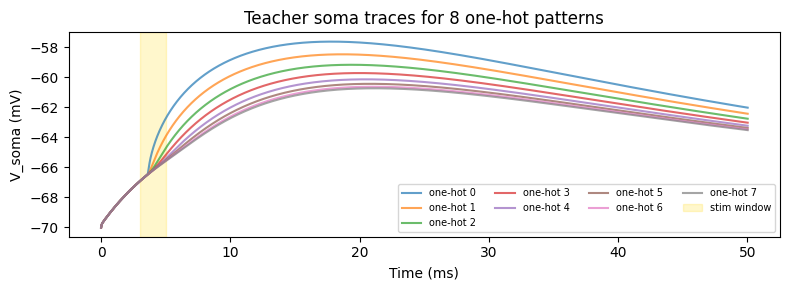

In [20]:
# ══════════════════════════════════════════════════════════════════════
# Cell 2 — Parameter setup, one-hot patterns, teacher targets
# ══════════════════════════════════════════════════════════════════════

# ── Trained parameters (recovered from initial_grads.ipynb) ──
gS_true = params_true[0]["IonotropicSynapse_gS"]
gS_learned = jnp.array([
    1.00277919e-04, 9.97798681e-05, 1.00300902e-04, 9.99215627e-05,
    1.00301055e-04, 1.00781421e-04, 1.00418767e-04, 1.00494627e-04,
])

params_true     = [{"IonotropicSynapse_gS": gS_true}]

transform = jx.ParamTransform([
    {"IonotropicSynapse_gS": jt.SigmoidTransform(1e-5, 1e-2)},
])
opt_params_learned = transform.inverse([{"IonotropicSynapse_gS": gS_learned}])
params_analysis = transform.forward(opt_params_learned)

print("gS_true:   ", gS_true)
print("gS_learned:", params_analysis[0]["IonotropicSynapse_gS"])
print(f"max |diff|: {float(jnp.max(jnp.abs(gS_true - gS_learned))):.2e}")

# ── One-hot patterns  (8, Nsyn) ──
patterns_onehot = jnp.eye(Nsyn, dtype=jnp.float64)   # (8, 8)
print(f"\npatterns_onehot shape: {patterns_onehot.shape}")
print(patterns_onehot)

# ── Teacher targets for the 8 one-hots ──
targets_onehot = batched_simulate_soma(params_true, patterns_onehot)   # (8, T)
T = targets_onehot.shape[1]
t_arr = np.arange(T) * dt                                              # time axis

print(f"\ntargets_onehot shape: {targets_onehot.shape}")
print(f"T = {T},  dt = {dt} ms,  t_max = {t_max} ms")

# Quick sanity plot
fig, ax = plt.subplots(figsize=(8, 3))
for p in range(Nsyn):
    ax.plot(t_arr, targets_onehot[p], alpha=0.7, label=f"one-hot {p}")
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.2, label="stim window")
ax.set_xlabel("Time (ms)"); ax.set_ylabel("V_soma (mV)")
ax.set_title("Teacher soma traces for 8 one-hot patterns")
ax.legend(fontsize=7, ncol=4)
plt.tight_layout(); plt.show()


In [23]:
# ══════════════════════════════════════════════════════════════════════
# Part A1 — Parameter perturbation ensemble (Option B, log-normal)
# ══════════════════════════════════════════════════════════════════════

def generate_perturbations(params_base, M, sigma, seed=0):
    """
    Generate M perturbed parameter sets via multiplicative log-normal noise.

        g_i' = g_i · exp(σ · η_i),   η_i ~ N(0, 1)

    Only IonotropicSynapse_gS is perturbed; everything else stays unchanged.
    Returns:
        params_list  – list of M parameter dicts  [{"IonotropicSynapse_gS": …}]
        gS_all       – array (M, Nsyn) of perturbed conductances
    """
    gS_base = params_base[0]["IonotropicSynapse_gS"]          # (Nsyn,)
    key     = jax.random.PRNGKey(seed)
    eta     = jax.random.normal(key, shape=(M, Nsyn))          # (M, Nsyn)
    gS_all  = gS_base[None, :] * jnp.exp(sigma * eta)         # (M, Nsyn)

    params_list = [
        [{"IonotropicSynapse_gS": gS_all[m]}] for m in range(M)
    ]
    return params_list, gS_all


# Two sigma conditions
M = 500   # baseline ensemble size (increase to 500 if runtime permits)

params_s005, gS_s005 = generate_perturbations(params_analysis, M, sigma=0.05, seed=42)
params_s010, gS_s010 = generate_perturbations(params_analysis, M, sigma=0.10, seed=42)

print(f"Generated {M} perturbations for σ=0.05 and σ=0.10")
print(f"\nσ=0.05  gS range: [{float(gS_s005.min()):.6e}, {float(gS_s005.max()):.6e}]")
print(f"σ=0.10  gS range: [{float(gS_s010.min()):.6e}, {float(gS_s010.max()):.6e}]")
print(f"\nAll positive?  σ=0.05: {bool((gS_s005 > 0).all())}   "
      f"σ=0.10: {bool((gS_s010 > 0).all())}")
print(f"Any NaN?       σ=0.05: {bool(jnp.isnan(gS_s005).any())}   "
      f"σ=0.10: {bool(jnp.isnan(gS_s010).any())}")


Generated 500 perturbations for σ=0.05 and σ=0.10

σ=0.05  gS range: [8.339964e-05, 1.206398e-04]
σ=0.10  gS range: [6.934622e-05, 1.451030e-04]

All positive?  σ=0.05: True   σ=0.10: True
Any NaN?       σ=0.05: False   σ=0.10: False


In [24]:
# ══════════════════════════════════════════════════════════════════════
# Part A2 — Sanity checks on perturbations
# ══════════════════════════════════════════════════════════════════════

p_test  = 0                                   # one-hot pattern index
pat_ex  = patterns_onehot[p_test]
tgt_ex  = targets_onehot[p_test]
n_check = 5

grads_ck, V_ck = [], []

# baseline (unperturbed)
gw0, tr0, lo0 = single_trial(params_analysis, pat_ex, tgt_ex)
grads_ck.append(np.asarray(gw0));  V_ck.append(np.asarray(tr0))

# a few perturbations (sigma=0.10)
for m in range(n_check):
    gw_m, tr_m, _ = single_trial(params_s010[m], pat_ex, tgt_ex)
    grads_ck.append(np.asarray(gw_m));  V_ck.append(np.asarray(tr_m))

grads_ck = np.stack(grads_ck)          # (n_check+1, Nsyn)
V_ck     = np.stack(V_ck)              # (n_check+1, Nsyn, T)

print("Gradient std across perturbations (per synapse):")
print(f"  std = {grads_ck.std(axis=0)}")
print(f"  nonzero std for every synapse? {bool((grads_ck.std(axis=0) > 0).all())}")

print(f"\nVoltage max-std over time (per recording site):")
for j in range(Nsyn):
    print(f"  site {j}: max std = {V_ck[:, j, :].std(axis=0).max():.4f} mV")

print(f"\nParameters valid?  all gS > 0: {bool((gS_s010 > 0).all())}  "
      f"no NaN: {bool(~jnp.isnan(gS_s010).any())}")
print("\n✓ Perturbations produce non-trivial variation in grads and voltages")


Gradient std across perturbations (per synapse):
  std = [29684.30292393  5248.70784045  4424.65548515  3766.27310038
  3267.57404919  2911.68676037  2686.35435655  2587.21883018]
  nonzero std for every synapse? True

Voltage max-std over time (per recording site):
  site 0: max std = 0.3576 mV
  site 1: max std = 0.2948 mV
  site 2: max std = 0.2412 mV
  site 3: max std = 0.1943 mV
  site 4: max std = 0.1685 mV
  site 5: max std = 0.1552 mV
  site 6: max std = 0.1463 mV
  site 7: max std = 0.1398 mV

Parameters valid?  all gS > 0: True  no NaN: True

✓ Perturbations produce non-trivial variation in grads and voltages


In [7]:
# ══════════════════════════════════════════════════════════════════════
# Part B1 — Dataset generation loop  (M perturbations × 8 one-hots)
# ══════════════════════════════════════════════════════════════════════
# Primary condition: σ = 0.10
sigma_primary   = 0.10
params_ensemble = params_s010
M_run           = M                   # 200
n_patterns      = Nsyn                # 8 one-hot patterns

# Pre-allocate  ──  shapes follow the spec
GRADS_ens = np.zeros((M_run, n_patterns, Nsyn))          # (M, 8, Nsyn)
VALL_ens  = np.zeros((M_run, n_patterns, Nsyn, T))       # (M, 8, Nsyn, T)
LOSS_ens  = np.zeros((M_run, n_patterns))                # (M, 8)

print(f"Running {M_run} perturbations × {n_patterns} patterns "
      f"= {M_run * n_patterns} trials  (σ={sigma_primary}) ...")
print(f"GRADS  {GRADS_ens.shape}   VALL  {VALL_ens.shape}   LOSS  {LOSS_ens.shape}")

import time as _time
_t0 = _time.time()

for m in range(M_run):
    if m % 25 == 0:
        elapsed = _time.time() - _t0
        print(f"  m={m:4d}/{M_run}  ({elapsed:.1f}s)")

    ((losses_m, traces_m), grads_m) = batched_vg(
        params_ensemble[m], patterns_onehot, targets_onehot,
    )
    # grads_m is a tree with same structure as params; extract gS
    GRADS_ens[m] = np.asarray(grads_m[0]["IonotropicSynapse_gS"])   # (8, Nsyn)
    VALL_ens[m]  = np.asarray(traces_m)                              # (8, Nsyn, T)
    LOSS_ens[m]  = np.asarray(losses_m)                              # (8,)

elapsed = _time.time() - _t0
print(f"\nDone in {elapsed:.1f}s  ({elapsed / M_run:.2f}s per perturbation)")
print(f"GRADS  {GRADS_ens.shape}   VALL  {VALL_ens.shape}   LOSS  {LOSS_ens.shape}")
print(f"LOSS range: [{LOSS_ens.min():.2f}, {LOSS_ens.max():.2f}]")

# ── Save to disk ──
save_dir  = "/n/home12/isanchez/jaxneuro/outputs"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "perturbation_onehot_dataset.npz")

np.savez(
    save_path,
    GRADS=GRADS_ens,
    VALL=VALL_ens,
    LOSS=LOSS_ens,
    patterns_onehot=np.asarray(patterns_onehot),
    gS_perturbed=np.asarray(gS_s010),
    syn_post_comp_indices=syn_post_comp_indices,
    dt=dt, t_max=t_max, i_delay=i_delay, i_dur=i_dur,
    M=M_run, Nsyn=Nsyn, sigma=sigma_primary,
)

fsize = os.path.getsize(save_path)
print(f"\nSaved → {save_path}  ({fsize / 1e6:.1f} MB)")


Running 200 perturbations × 8 patterns = 1600 trials  (σ=0.1) ...
GRADS  (200, 8, 8)   VALL  (200, 8, 8, 2002)   LOSS  (200, 8)
  m=   0/200  (0.0s)
  m=  25/200  (27.0s)
  m=  50/200  (45.9s)
  m=  75/200  (64.8s)
  m= 100/200  (83.8s)
  m= 125/200  (102.7s)
  m= 150/200  (121.6s)
  m= 175/200  (140.5s)

Done in 159.5s  (0.80s per perturbation)
GRADS  (200, 8, 8)   VALL  (200, 8, 8, 2002)   LOSS  (200, 8)
LOSS range: [0.00, 3.24]

Saved → /n/home12/isanchez/jaxneuro/outputs/perturbation_onehot_dataset.npz  (205.1 MB)


ALIGNMENT REPORT

For each one-hot pattern p, which gradient component has the largest mean |grad| across the 200-member ensemble?

 Pattern p           Bit vector   argmax |grad|  |grad| at p   Match?
------------------------------------------------------------------------
         0             10000000               0     3.99e+04        ✓
         1             01000000               1     3.23e+04        ✓
         2             00100000               2     2.36e+04        ✓
         3             00010000               3     1.82e+04        ✓
         4             00001000               4     1.42e+04        ✓
         5             00000100               5     1.19e+04        ✓
         6             00000010               6     1.06e+04        ✓
         7             00000001               7     9.67e+03        ✓

Dominant gradient matches one-hot index: 8/8


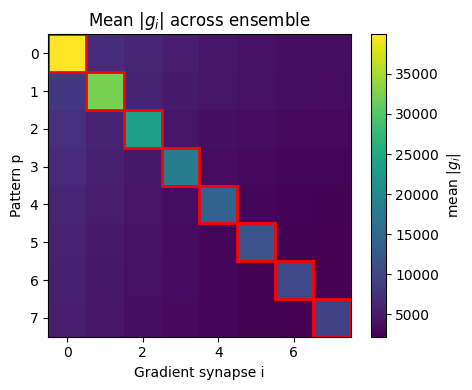

In [8]:
# ══════════════════════════════════════════════════════════════════════
# Part B2 — Alignment report
# ══════════════════════════════════════════════════════════════════════
print("=" * 72)
print("ALIGNMENT REPORT")
print("=" * 72)
print(f"\nFor each one-hot pattern p, which gradient component has the "
      f"largest mean |grad| across the {M_run}-member ensemble?\n")
print(f"{'Pattern p':>10} {'Bit vector':>20} {'argmax |grad|':>15} "
      f"{'|grad| at p':>12} {'Match?':>8}")
print("-" * 72)

n_match = 0
for p in range(Nsyn):
    mean_abs_grad = np.mean(np.abs(GRADS_ens[:, p, :]), axis=0)   # (Nsyn,)
    dominant_idx  = int(np.argmax(mean_abs_grad))
    match         = dominant_idx == p
    n_match      += int(match)
    bits = "".join(np.asarray(patterns_onehot[p]).astype(int).astype(str))
    print(f"{p:>10} {bits:>20} {dominant_idx:>15} "
          f"{mean_abs_grad[p]:>12.2e} {'✓' if match else '✗':>8}")

print(f"\nDominant gradient matches one-hot index: {n_match}/{Nsyn}")

# Also show full mean |grad| matrix (patterns × synapses)
mean_abs_G = np.mean(np.abs(GRADS_ens), axis=0)   # (8, 8)
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(mean_abs_G, cmap="viridis")
ax.set_xlabel("Gradient synapse i"); ax.set_ylabel("Pattern p")
ax.set_title(r"Mean $|g_i|$ across ensemble")
for p in range(Nsyn):
    ax.add_patch(plt.Rectangle((p - 0.5, p - 0.5), 1, 1,
                                fill=False, ec="red", lw=2))
plt.colorbar(im, ax=ax, label=r"mean $|g_i|$")
plt.tight_layout(); plt.show()

print("=" * 72)


In [9]:
# ══════════════════════════════════════════════════════════════════════
# Part C — Feature extraction  (ΔV, AUC, VMAX, SLOPE)
# ══════════════════════════════════════════════════════════════════════

# ── C0: Window definitions ──
tail_ms = 20.0                                  # ms of post-stimulus tail
W_start = i_delay                               # stimulus + tail start
W_end   = i_delay + i_dur + tail_ms             # stimulus + tail end
B_start = 0.0                                   # baseline start
B_end   = i_delay                               # baseline end

W_mask = (t_arr >= W_start) & (t_arr <= W_end)  # stimulus+tail window
B_mask = (t_arr >= B_start) & (t_arr <  B_end)  # pre-stim baseline

print(f"Stimulus+tail window W: [{W_start:.1f}, {W_end:.1f}] ms  "
      f"→ {W_mask.sum()} timepoints")
print(f"Baseline window B:      [{B_start:.1f}, {B_end:.1f}) ms  "
      f"→ {B_mask.sum()} timepoints")

# ── C1: Baseline-subtracted voltage ──
# ΔV(m,p,j,t) = V(m,p,j,t) − mean_{t∈B} V(m,p,j,t)
V_baseline = VALL_ens[:, :, :, B_mask].mean(axis=3, keepdims=True)  # (M,8,Nsyn,1)
DV = VALL_ens - V_baseline                                          # (M,8,Nsyn,T)

print(f"\nΔV shape: {DV.shape}   ({DV.nbytes / 1e6:.1f} MB)")

# ── C2: Scalar features per (m, p, j) computed over window W ──
DV_W = DV[:, :, :, W_mask]                         # (M, 8, Nsyn, |W|)

# 1) AUC  (positive only)
AUC = np.maximum(DV_W, 0).sum(axis=3) * dt         # (M, 8, Nsyn)

# 2) Max depolarisation
VMAX = DV_W.max(axis=3)                             # (M, 8, Nsyn)

# 3) Peak slope  (finite-diff dV/dt, then max in W)
dVdt_full   = np.diff(DV, axis=3) / dt              # (M, 8, Nsyn, T-1)
W_slope_mask = W_mask[:-1]                           # T-1 boolean for diff'd axis
SLOPE = dVdt_full[:, :, :, W_slope_mask].max(axis=3) # (M, 8, Nsyn)

print(f"AUC   shape: {AUC.shape}")
print(f"VMAX  shape: {VMAX.shape}")
print(f"SLOPE shape: {SLOPE.shape}")

# ── C3: Time-resolved ΔV kept in DV (full T) for Part D1 ──
print(f"\nFull ΔV retained for time-resolved analysis  "
      f"({DV.nbytes / 1e6:.1f} MB)")


Stimulus+tail window W: [3.0, 25.0] ms  → 881 timepoints
Baseline window B:      [0.0, 3.0) ms  → 120 timepoints

ΔV shape: (200, 8, 8, 2002)   (205.0 MB)
AUC   shape: (200, 8, 8)
VMAX  shape: (200, 8, 8)
SLOPE shape: (200, 8, 8)

Full ΔV retained for time-resolved analysis  (205.0 MB)


R_time shape: (8, 8, 8, 2002)  (p, i, j, T)


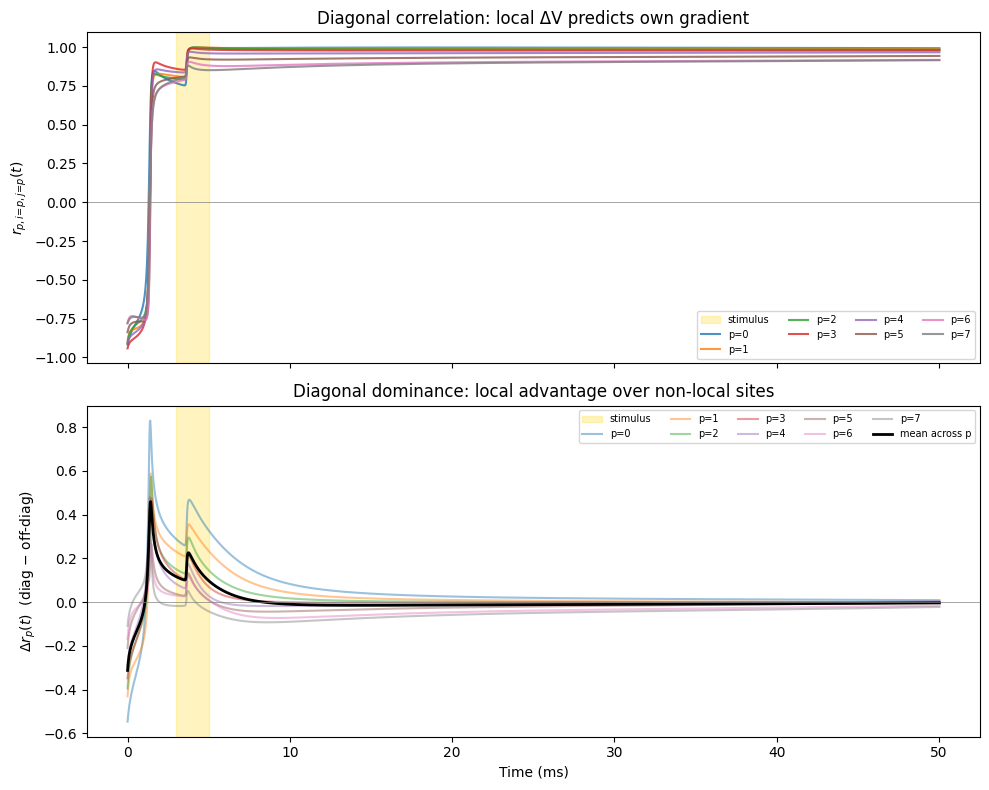

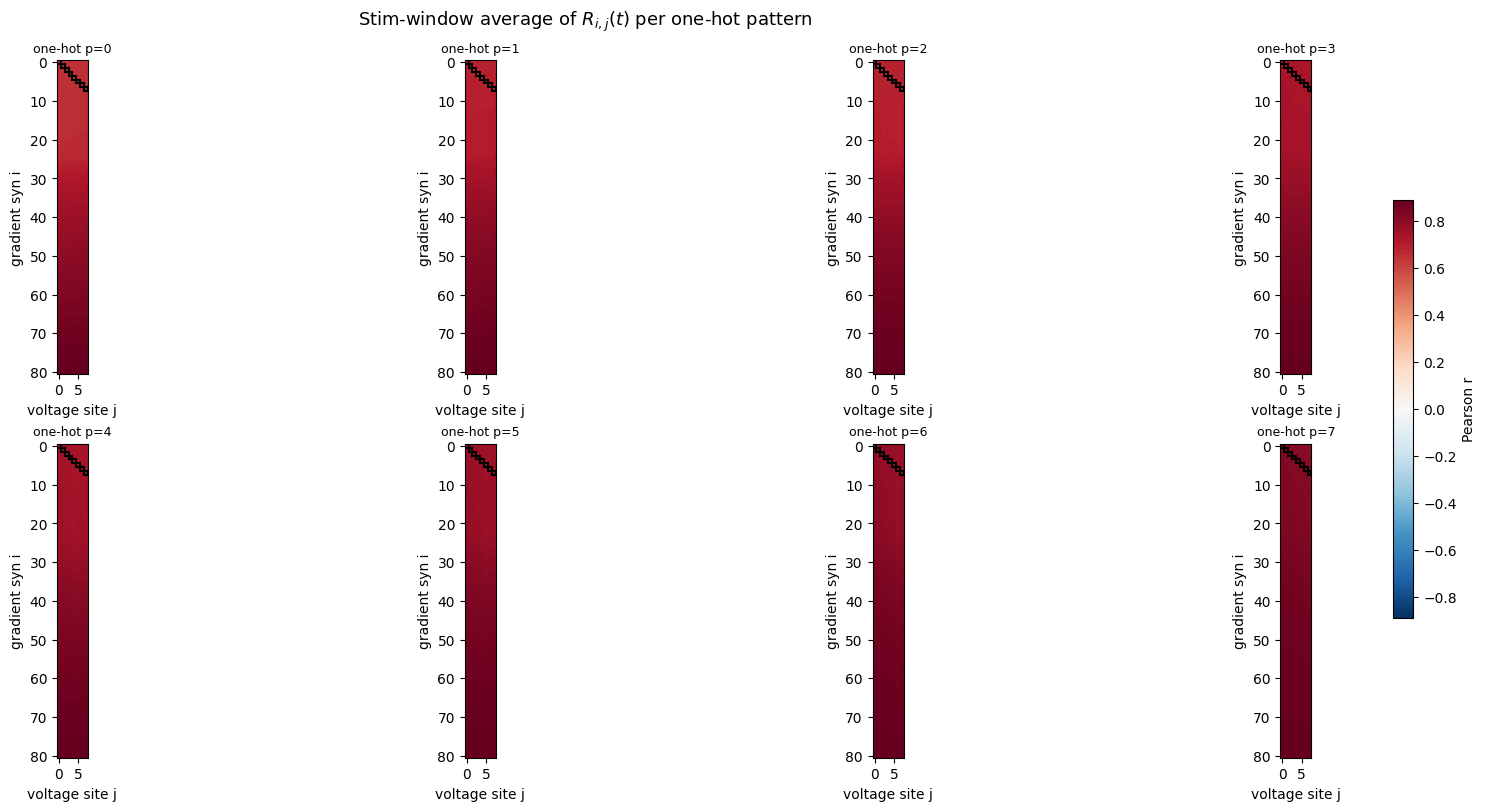

In [10]:
# ══════════════════════════════════════════════════════════════════════
# Part D1 — Time-resolved correlation curves
# ══════════════════════════════════════════════════════════════════════
#
# r_{p,i,j}(t) = corr_m( ΔV_{m,p,j}(t),  GRADS_{m,p,i} )
#
# Correlation is across the ensemble index m.
# ──────────────────────────────────────────────────────────────────────

def corr_vs_time(X, y, eps=1e-12):
    """Pearson r between columns of X and scalar y, across rows (axis 0).
    X : (M, T)    y : (M,)    → (T,)
    """
    X_dm = X - X.mean(axis=0, keepdims=True)
    y_dm = y - y.mean()
    num   = (X_dm * y_dm[:, None]).sum(axis=0)              # (T,)
    denom = np.sqrt((X_dm**2).sum(axis=0) * (y_dm**2).sum()) + eps
    return num / denom


# Full tensor: R_time[p, i, j, t]
R_time = np.zeros((Nsyn, Nsyn, Nsyn, T))

for p in range(Nsyn):
    for i in range(Nsyn):
        g_pi = GRADS_ens[:, p, i]                           # (M,)
        for j in range(Nsyn):
            R_time[p, i, j, :] = corr_vs_time(
                DV[:, p, j, :], g_pi
            )

print(f"R_time shape: {R_time.shape}  (p, i, j, T)")

# ─── Plot 1: Diagonal curves  r_{p, i=p, j=p}(t) ───
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax = axes[0]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25, label="stimulus")
for p in range(Nsyn):
    ax.plot(t_arr, R_time[p, p, p, :], label=f"p={p}", alpha=0.8)
ax.set_ylabel(r"$r_{p,i\!=\!p,j\!=\!p}(t)$")
ax.set_title("Diagonal correlation: local ΔV predicts own gradient")
ax.legend(fontsize=7, ncol=4)
ax.axhline(0, color="grey", lw=0.5)

# ─── Plot 2: Diagonal dominance  Δr_p(t) ───
# Δr_p(t) = r_{p,i=p,j=p}(t) − mean_{j≠p} r_{p,i=p,j}(t)
delta_r = np.zeros((Nsyn, T))
for p in range(Nsyn):
    r_diag    = R_time[p, p, p, :]
    r_offdiag = np.mean(
        [R_time[p, p, j, :] for j in range(Nsyn) if j != p], axis=0
    )
    delta_r[p] = r_diag - r_offdiag

ax = axes[1]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25, label="stimulus")
for p in range(Nsyn):
    ax.plot(t_arr, delta_r[p], alpha=0.45, label=f"p={p}")
ax.plot(t_arr, delta_r.mean(axis=0), "k", lw=2, label="mean across p")
ax.set_ylabel(r"$\Delta r_p(t)$  (diag − off-diag)")
ax.set_xlabel("Time (ms)")
ax.set_title("Diagonal dominance: local advantage over non-local sites")
ax.legend(fontsize=7, ncol=5)
ax.axhline(0, color="grey", lw=0.5)

plt.tight_layout()
plt.show()

# ─── Plot 3: Full R_{i,j} heatmap at stim-window average, per pattern ───
fig, axes = plt.subplots(2, 4, figsize=(18, 8), constrained_layout=True)
stim_mask = (t_arr >= i_delay) & (t_arr <= i_delay + i_dur)

for p in range(Nsyn):
    ax  = axes[p // 4, p % 4]
    mat = R_time[p, :, :, stim_mask].mean(axis=2)    # (i, j)  stim-avg
    vmax = max(np.abs(mat).max(), 0.01)
    im = ax.imshow(mat, cmap="RdBu_r", vmin=-vmax, vmax=vmax)
    ax.set_title(f"one-hot p={p}", fontsize=9)
    ax.set_xlabel("voltage site j"); ax.set_ylabel("gradient syn i")
    for d in range(Nsyn):
        ax.add_patch(plt.Rectangle((d-0.5, d-0.5), 1, 1,
                                    fill=False, ec="k", lw=1.5))
plt.colorbar(im, ax=axes.ravel().tolist(), label="Pearson r", shrink=0.6)
fig.suptitle(r"Stim-window average of $R_{i,j}(t)$ per one-hot pattern",
             fontsize=13)
plt.show()


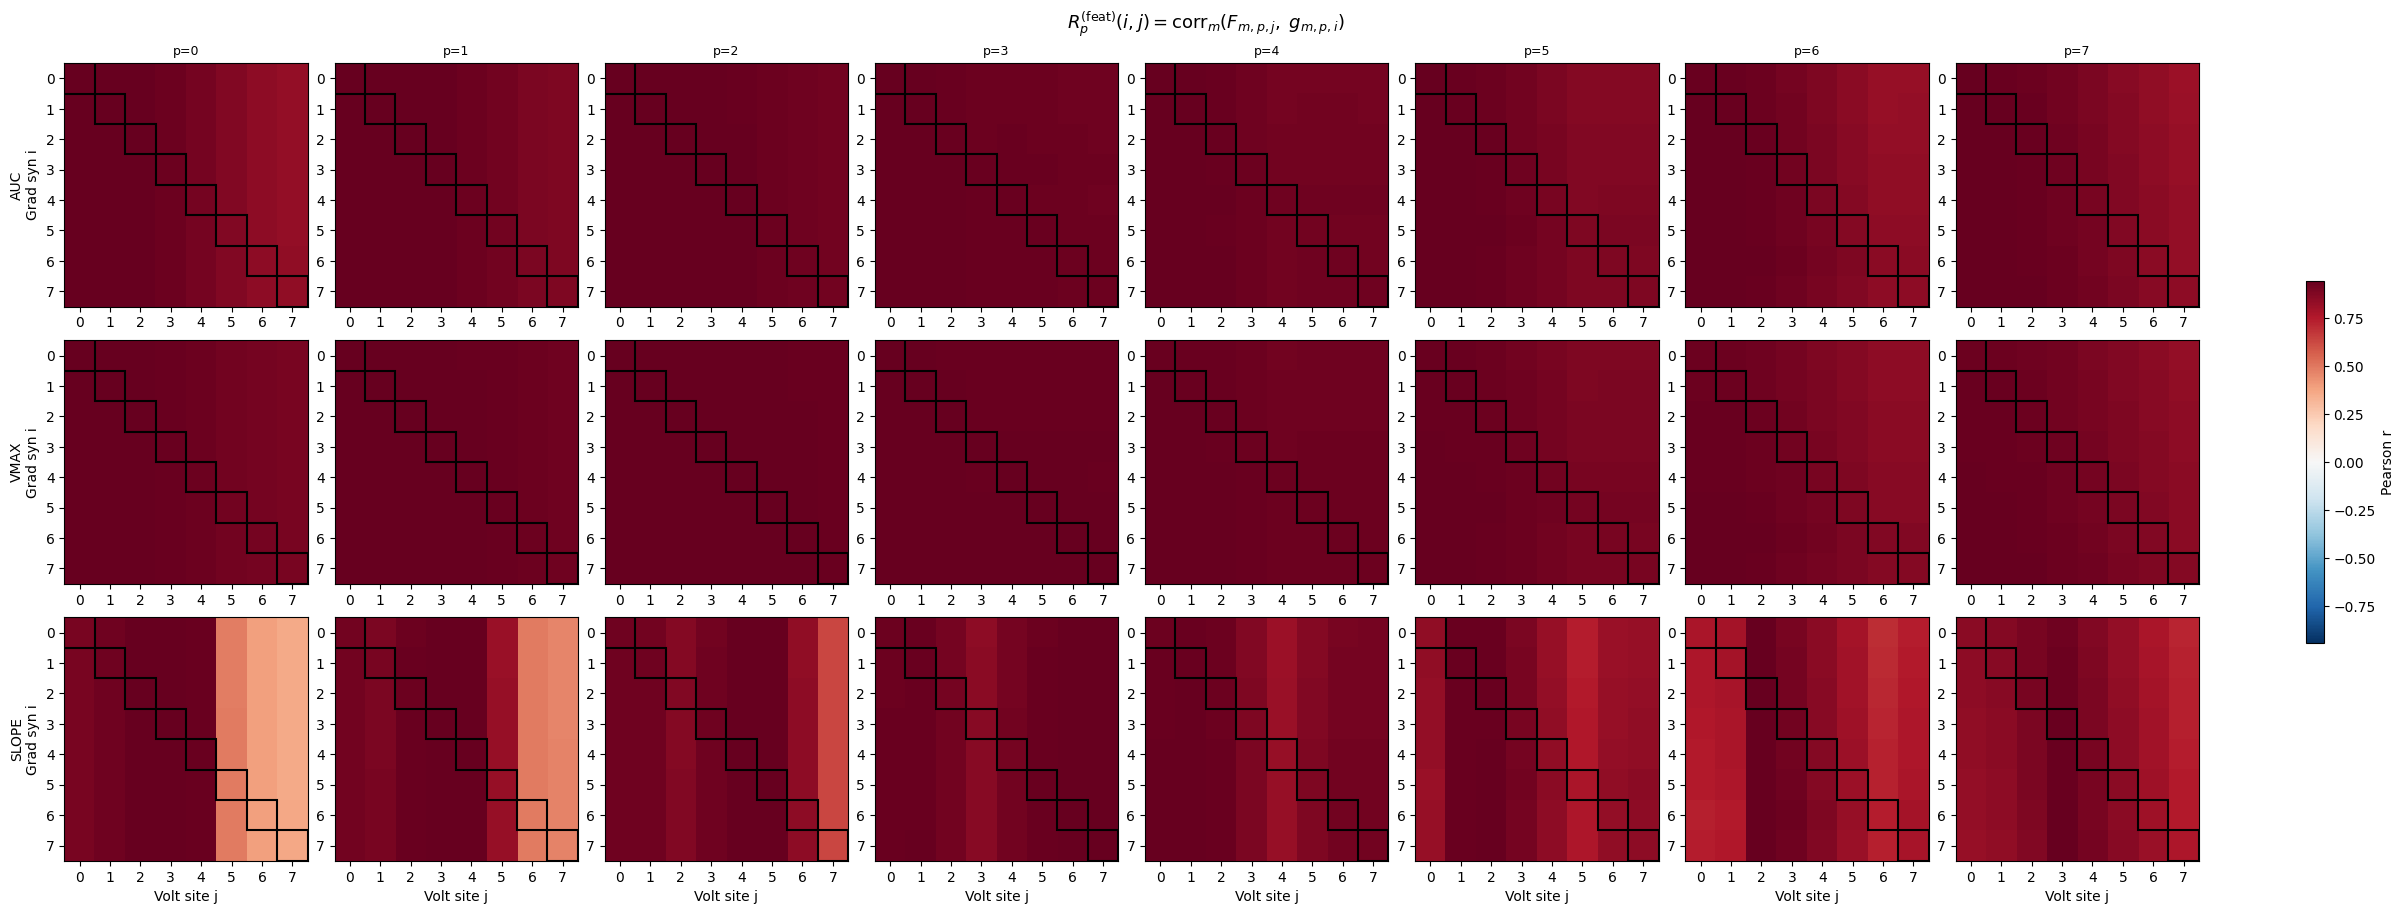

Feature → gradient diagonal dominance summary
 Feature  Pattern  diag_mean  offdiag_mean  diag/offdiag
------------------------------------------------------------
     AUC        0     0.9529        0.9526          1.00
     AUC        1     0.9726        0.9724          1.00
     AUC        2     0.9795        0.9795          1.00
     AUC        3     0.9792        0.9789          1.00
     AUC        4     0.9707        0.9697          1.00
     AUC        5     0.9545        0.9524          1.00
     AUC        6     0.9426        0.9392          1.00
     AUC        7     0.9450        0.9418          1.00
------------------------------------------------------------
    VMAX        0     0.9768        0.9766          1.00
    VMAX        1     0.9856        0.9855          1.00
    VMAX        2     0.9844        0.9845          1.00
    VMAX        3     0.9784        0.9783          1.00
    VMAX        4     0.9657        0.9652          1.00
    VMAX        5     0.9454      

In [11]:
# ══════════════════════════════════════════════════════════════════════
# Part D2 — Feature-to-gradient correlation matrices
# ══════════════════════════════════════════════════════════════════════
#
# For each pattern p and feature F ∈ {AUC, VMAX, SLOPE}:
#   R_p^(F)(i,j) = corr_m( F_{m,p,j},  GRADS_{m,p,i} )
#
# → (Nsyn × Nsyn) matrix per (feature, pattern)
# ──────────────────────────────────────────────────────────────────────

def corr_1d(x, y, eps=1e-12):
    """Pearson r between two 1-D arrays."""
    xd = x - x.mean()
    yd = y - y.mean()
    return float((xd * yd).sum() / (np.sqrt((xd**2).sum() * (yd**2).sum()) + eps))


def feature_grad_matrix(FEAT, GRADS_ens, p):
    """R(i,j) = corr_m(FEAT[m,p,j], GRADS[m,p,i])  → (Nsyn, Nsyn)."""
    R = np.zeros((Nsyn, Nsyn))
    for i in range(Nsyn):
        for j in range(Nsyn):
            R[i, j] = corr_1d(FEAT[:, p, j], GRADS_ens[:, p, i])
    return R


feature_names  = ["AUC", "VMAX", "SLOPE"]
feature_arrays = [AUC, VMAX, SLOPE]

R_feat = {}   # key = (feat_name, p) → (Nsyn, Nsyn)
for fn, fa in zip(feature_names, feature_arrays):
    for p in range(Nsyn):
        R_feat[(fn, p)] = feature_grad_matrix(fa, GRADS_ens, p)

# ─── Heatmaps: 3 features × 8 patterns ───
fig, axes = plt.subplots(3, Nsyn, figsize=(3 * Nsyn, 3 * 3),
                         constrained_layout=True)

for row, fn in enumerate(feature_names):
    for col in range(Nsyn):
        ax  = axes[row, col]
        mat = R_feat[(fn, col)]
        vm  = max(np.abs(mat).max(), 0.01)
        im  = ax.imshow(mat, cmap="RdBu_r", vmin=-vm, vmax=vm)
        for d in range(Nsyn):
            ax.add_patch(plt.Rectangle((d-0.5, d-0.5), 1, 1,
                                        fill=False, ec="k", lw=1.5))
        if row == 0:
            ax.set_title(f"p={col}", fontsize=9)
        if col == 0:
            ax.set_ylabel(f"{fn}\nGrad syn i")
        if row == 2:
            ax.set_xlabel("Volt site j")
        ax.set_xticks(range(Nsyn))
        ax.set_yticks(range(Nsyn))

plt.colorbar(im, ax=axes.ravel().tolist(), label="Pearson r", shrink=0.45)
fig.suptitle(
    r"$R_p^{(\mathrm{feat})}(i,j) = \mathrm{corr}_m(F_{m,p,j},\;g_{m,p,i})$",
    fontsize=13)
plt.show()

# ─── Summary table: diagonal dominance ───
print("=" * 80)
print("Feature → gradient diagonal dominance summary")
print("=" * 80)
print(f"{'Feature':>8} {'Pattern':>8} {'diag_mean':>10} "
      f"{'offdiag_mean':>13} {'diag/offdiag':>13}")
print("-" * 60)

for fn in feature_names:
    for p in range(Nsyn):
        mat = R_feat[(fn, p)]
        diag_vals = np.array([mat[i, i] for i in range(Nsyn)])
        off_mask  = ~np.eye(Nsyn, dtype=bool)
        off_vals  = mat[off_mask]

        diag_mean = np.abs(diag_vals).mean()
        off_mean  = np.abs(off_vals).mean()
        ratio     = diag_mean / (off_mean + 1e-12)

        print(f"{fn:>8} {p:>8} {diag_mean:>10.4f} "
              f"{off_mean:>13.4f} {ratio:>13.2f}")
    print("-" * 60)

# ─── Aggregate across patterns ───
print("\n" + "=" * 80)
print("Aggregate across patterns (mean ± std of per-pattern ratios)")
print("=" * 80)
print(f"{'Feature':>8} {'mean diag/off':>14} {'std':>8}")
print("-" * 35)
for fn in feature_names:
    ratios = []
    for p in range(Nsyn):
        mat = R_feat[(fn, p)]
        diag_m = np.abs(np.diag(mat)).mean()
        off_m  = np.abs(mat[~np.eye(Nsyn, dtype=bool)]).mean()
        ratios.append(diag_m / (off_m + 1e-12))
    ratios = np.array(ratios)
    print(f"{fn:>8} {ratios.mean():>14.2f} {ratios.std():>8.2f}")
print("=" * 80)
